# Validation of mutations associated with IFN+ cells

This notebook re-plots Alistair's validation experiments where his A549 IFNL1 reporter cells were infected with mutants of influenza virus identified in IFN+ cells in the single-cell experiment.

Load Python packages:

In [1]:
import itertools
import collections

import pandas
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

from dms_tools2.plot import COLOR_BLIND_PALETTE_GRAY as PALETTE
from dms_tools2.ipython_utils import showPDF

Define plotting grid:

In [2]:
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

Read data for all replicates and conditions, putting HA and IFN on log scale.
The data come from two separate experiments (one focused on SNPs and one on deletions), and can be compared within experiments but not between them since they were done on different days.
When reading in the mutants, we re-name according to names that match the rest of the paper.
We also re-name replicates for SNP experiment according to fact that they are actually two technical replicates of two biological replicates of virus.

The experiments are: 

 1. SNP experiment: viruses were normalized by HI titer, with the wildtype replicate 1 set to a MOI of 0.1 by TICID50. There are two biological replicates of each virus, each performed in technical replicate. The first biological replicate was harvested at 50 hours post-transfection. The second was harvested at 48 hours post-transfection (wildtype) or 72 hours (all others). 
 2. Deletion experiment: the viruses were normalized by TCID50 and infected at a MOI of 0.3 qPCR on virions indicating similar particle to virion infectivity. In addition, equivalent amounts of HA were checked by qPCR on infections treated with cycloheximide.

In [3]:
experiments = {
    'SNP':collections.OrderedDict([
        ('uninfected', 'uninfected'),
        ('wild-type', 'wildtype'),
        ('NS1mut', 'NS1stop'),
        ('PB1_G103A', 'PB1-D27N'),
        ('PB1_G640A', 'PB1-G206S'),
        ('PB1_A860G', 'PB1-K279R'),
        ('PB1_A2053G', 'PB1-T677A'),
        ('NS_C391T', 'NS1-A122V'),
        ('NS_A638G', 'NS2-E47G'),
        ]),
    'del':collections.OrderedDict([
        ('uninfected', 'uninfected'),
        ('wild-type', 'wildtype'),
        ('NS1-stop', 'NS1stop'),
        ('PB1d386-2167', 'PB1del385to2163'),
        ]),
    }

replicates = collections.defaultdict(dict)
for expt, samples in experiments.items():
    for sample in samples.values():
        if expt == 'SNP' and sample != "uninfected":
            replicates[expt][sample] = collections.OrderedDict([
                    ('1', '1a'),
                    ('2', '1b'),
                    ('3', '2a'),
                    ('4', '2b'),
                    ])
        else:
            replicates[expt][sample] = collections.OrderedDict([
                    ('1', '1'),
                    ('2', '2'),
                    ('3', '3'),
                    ])

flow_data = (
    pandas.concat(
        [pandas.read_csv(f'flow/{expt}/{sname}_{repname}.csv')
               .assign(experiment=expt,
                       sample=sample,
                       replicate=rep
                       )
                for expt in experiments 
                for sname, sample in experiments[expt].items()
                for repname, rep in replicates[expt][sample].items()
        ])
    .rename(columns={'FITC-A':'IFN', 'APC-A':'HA'})
    # set <= values to smallest > 0 value
    .assign(minHA=lambda x: x.query('HA > 0').HA.min(),
            HA=lambda x: np.where(x.HA < x.minHA, x.minHA, x.HA),
            minIFN=lambda x: x.query('IFN > 0').IFN.min(),
            IFN=lambda x: np.where(x.IFN < x.minIFN, x.minIFN, x.IFN))
    .assign(HA=lambda x: np.log10(x.HA),
            IFN=lambda x: np.log10(x.IFN))
    )

Set gates of 99.95th percentile for HA and IFN populations for each experiment separately:

In [4]:
gate_threshold = 0.9995

Make the flow plots, setting the gates and also computing percentages in the four HA+/- and IFN+/- quadrants along the way:

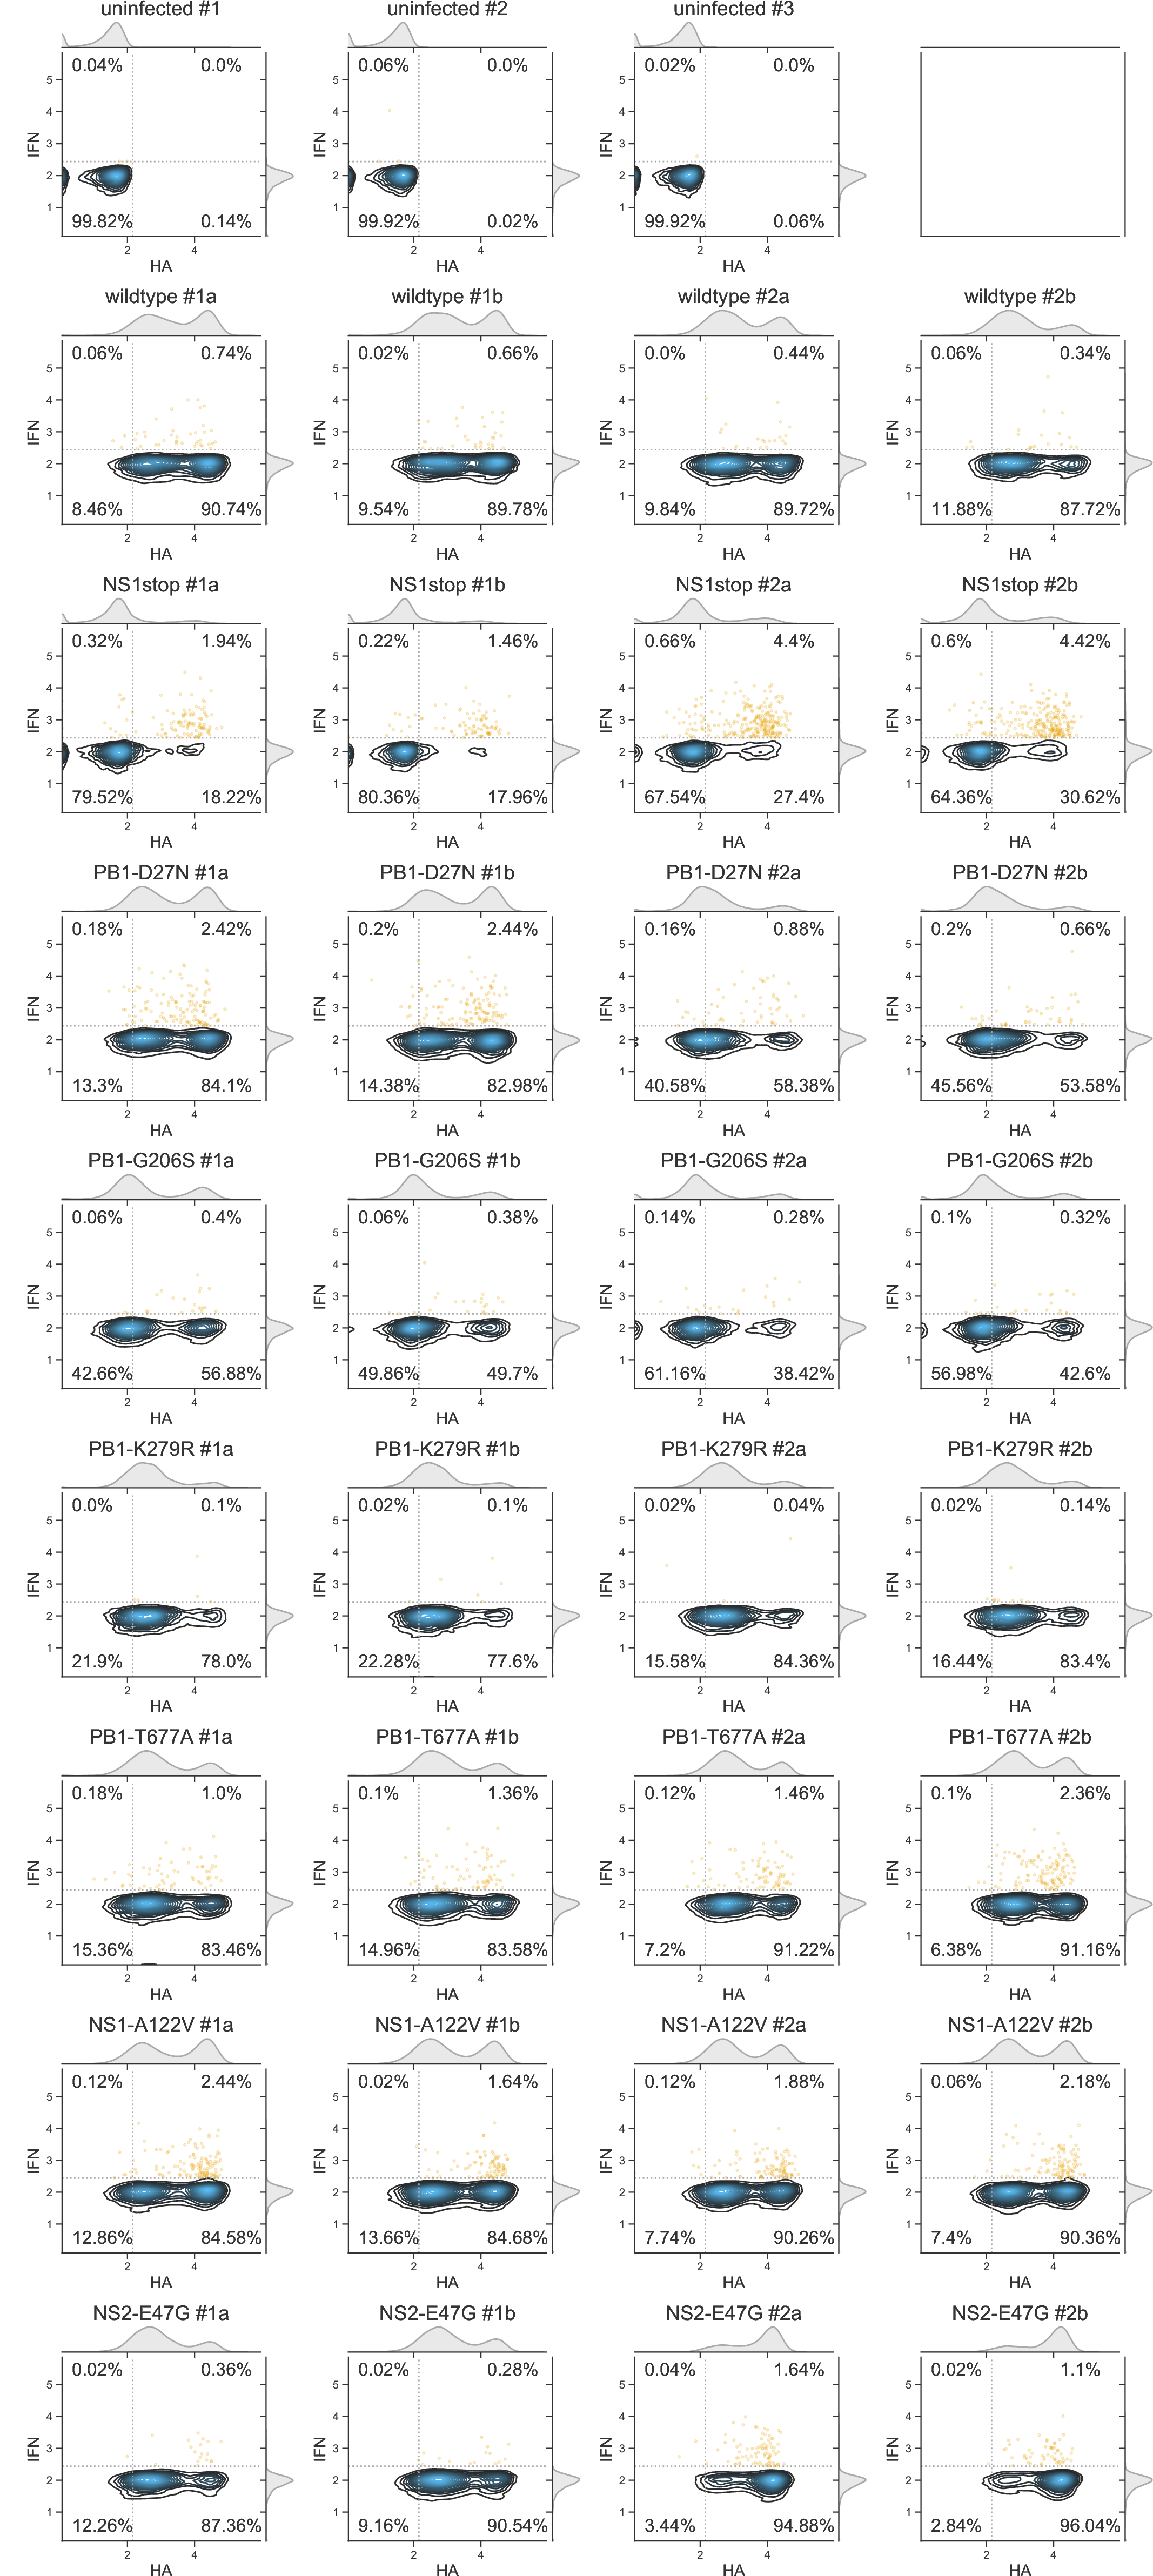

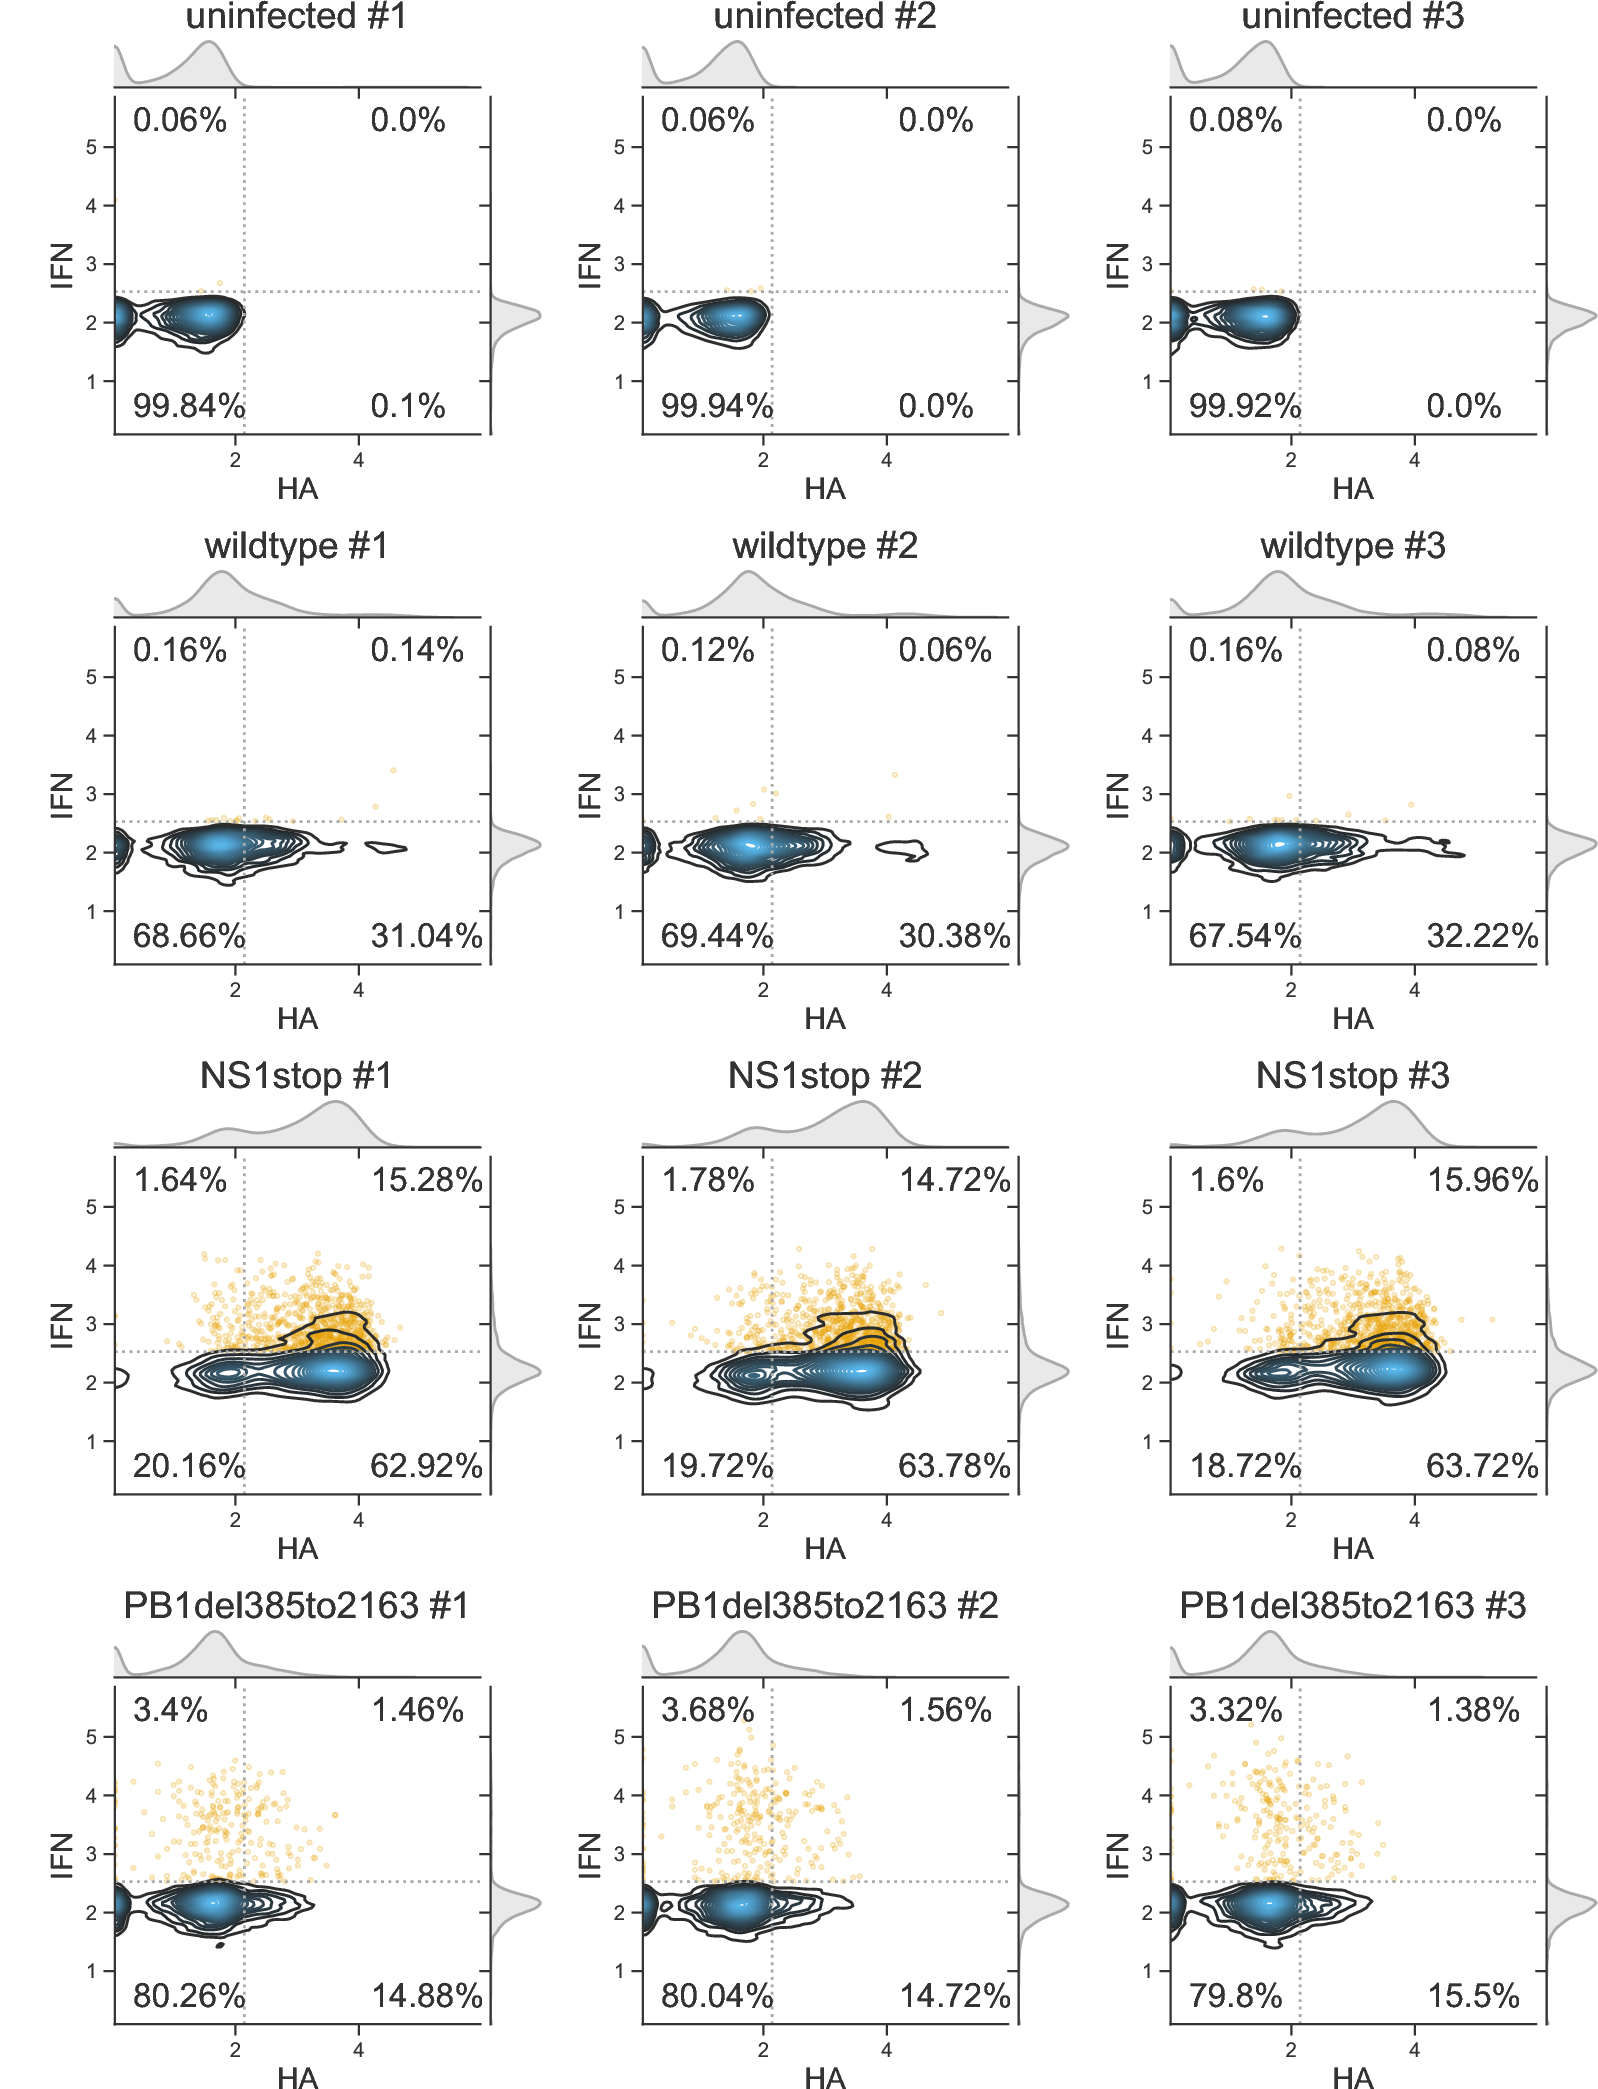

In [5]:
sns.set()
sns.set_style("white")
sns.set_style("ticks")

percents = []

for expt in experiments:
    
    expt_data = (flow_data
                 .query('experiment == @expt')
                 .assign(
                    threshold_HA=lambda x:
                        x.query('sample == "uninfected"')
                         .HA
                         .quantile(gate_threshold),
                    threshold_IFN=lambda x:
                        x.query('sample == "uninfected"')
                         .IFN
                         .quantile(gate_threshold),
                    HApos=lambda x: x.HA > x.threshold_HA,
                    IFNpos=lambda x: x.IFN > x.threshold_IFN)
                  )
    
    samples = expt_data['sample'].unique()
    nsamples = len(samples)
    nreplicates = max([len(replicates[expt][sample])
                       for sample in samples])
    
    gs = gridspec.GridSpec(nsamples, nreplicates)
    fig = plt.figure(figsize=(4 * nreplicates, 4 * nsamples))

    for i, (sample, ireplicate) in enumerate(
            [(s, i) for s in samples for i in range(nreplicates)]):
        
        ireplicates = list(replicates[expt][sample].values())
        if ireplicate < len(ireplicates):
            replicate = ireplicates[ireplicate]
        else:
            # blank spot
            g = sns.JointGrid(x=[0, 1], y=[0, 1])
            ax = g.ax_joint
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            SeabornFig2Grid(g, fig, gs[i])
            continue

        idata = (expt_data
                 .query("sample == @sample")
                 .query("replicate == @replicate")
                 )
        
        # begin debugging
        idata = idata.sample(min(5000, len(idata)))
        # end debugging
        
        g = (
            sns.JointGrid(x='HA', y='IFN', data=idata,
                          xlim=(flow_data.HA.min(),
                                1.1 * flow_data.HA.max()),
                          ylim=(flow_data.IFN.min(),
                                1.1 * flow_data.IFN.max()))
            .plot_joint(sns.kdeplot, n_levels=20, color=PALETTE[2])
            .plot_marginals(sns.kdeplot, shade=True, color=PALETTE[0])
            )
        ax = g.ax_joint
        sns.regplot(x='HA', y='IFN', data=idata.query('IFNpos'), 
                    color=PALETTE[1], ax=ax, 
                    scatter_kws={'s':5, 'alpha':0.3}, fit_reg=False)
        ax.axvline(x=idata.threshold_HA.values[0], c=PALETTE[0], ls=':')
        ax.axhline(y=idata.threshold_IFN.values[0], c=PALETTE[0], ls=':')
    
        n = len(idata) / 100.0 # divide by 100 to get percents
        HAnegIFNneg = len(idata.query('~HApos & ~IFNpos')) / n
        HAposIFNpos = len(idata.query('HApos & IFNpos')) / n
        HAposIFNneg = len(idata.query('HApos & ~IFNpos')) / n
        HAnegIFNpos = len(idata.query('~HApos & IFNpos')) / n
        percents.append((expt, sample, replicate, 
                         HAnegIFNneg, HAposIFNpos,
                         HAposIFNneg, HAnegIFNpos))
        ax.text(0.05, 0.05, str(round(HAnegIFNneg, 2)) + '%', 
                transform=ax.transAxes, fontsize=18)
        ax.text(0.05, 0.9, str(round(HAnegIFNpos, 2)) + '%', 
                transform=ax.transAxes, fontsize=18)
        ax.text(0.7, 0.05, str(round(HAposIFNneg, 2)) + '%', 
                transform=ax.transAxes, fontsize=18)
        ax.text(0.7, 0.9, str(round(HAposIFNpos, 2)) + '%', 
                transform=ax.transAxes, fontsize=18)
        ax.xaxis.label.set_size(16)
        ax.yaxis.label.set_size(16)
        
        SeabornFig2Grid(g, fig, gs[i])
    
        fig.get_axes()[1 + 3 * i].set_title(f'{sample} #{replicate}',
                                            fontsize=20)
    
    gs.tight_layout(fig)

    plotfile = f'{expt}_flow_plot.pdf'
    fig.savefig(plotfile)
    showPDF(plotfile, width=500)
    plt.close()

Calculate and write to CSV file the statistics on the percent of cells IFN+.

For the SNP experiment, we calculate IFN+ percentage only among HA+ cells, as they are the only ones that we consider to be infected.
For the uninfected cells, we simply calculate the total IFN+ cell percentage, since uninfected cells do not express HA.

For the del experiment, HA gating does not reliably identify infection as the PB1del virus clearly has lower HA staining as it can't undergo secondary transcription.
So for this experiment, we simply calculate IFN+ among all cells since the infecting dose was attempted to be normalized by qPCR prior to this infection.

In [6]:
ifn_stats = (
    pandas.DataFrame(
        percents,
        columns=['experiment', 'sample', 'replicate', 'HAnegIFNneg',
                 'HAposIFNpos', 'HAposIFNneg', 'HAnegIFNpos']
        )
    .assign(IFNpercent=lambda x: np.where(
        (x.sample == 'uninfected') | (x.experiment == 'del'),
        x.HAposIFNpos + x.HAnegIFNpos,
        100 * x.HAposIFNpos / (x.HAposIFNpos + x.HAposIFNneg),
        )
        )
    )

ifn_stats.to_csv('ifn_stats.csv', index=False)